# Gaussian Process regression Hemocell analysis

In [1]:
import numpy as np
import pandas as pd

from lxml import etree

import matplotlib.pyplot as plt

from scipy.stats import norm,uniform,multivariate_normal

from SALib.sample import saltelli
from SALib.analyze import sobol

from tqdm import tqdm

from sklearn.neighbors.kde import KernelDensity
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel,WhiteKernel

import UQLib.calibration.TMCMC as TMCMC

from local_config import *

#np.random.seed(6345789)

## Load training data

In [2]:
# Load simulation data
mode="visc"

imin = 0
imax = 6

# Load simulation data
x_train = np.load("%s/train_hemocell_samples_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
y_train = np.load("%s/train_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

# Remove failed simulation outputs
x_train = x_train[(y_train >= 0)[:,0],:-1]
y_train = y_train[y_train >= 0]

## Train prediction model

In [3]:
# Train prediction model
kernel = RBF(length_scale=1.0) + WhiteKernel()
predictionModel = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=1).fit(x_train,y_train)

## Sentivity Analysis

In [4]:
# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress = data.values[imin:imax,1]

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

In [5]:
n_samples = 1000

model_params = ["kLink","kBend","viscosityRatio"]

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Set the bounds on the parameters
bounds = [[10.0,300.0],
          [50.0,300.0],
          [1.0,15.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,n_samples,calc_second_order=False)

sobol_qoi = np.zeros((param_values.shape[0],shearrate.size))
sobol_cerr = np.zeros((param_values.shape[0],shearrate.size))

with tqdm(total=sobol_qoi.size) as pbar:
    for n,param_set in enumerate(param_values):
        for m,design_val in enumerate(shearrate):
            arr = np.array([*param_values[n],design_val])[None,:]
            mean,std = predictionModel.predict(arr,return_std=True)

            sobol_qoi[n,m] = mean
            sobol_cerr[n,m] = std
            
            pbar.update()

100%|██████████| 30000/30000 [00:16<00:00, 1832.10it/s]


In [6]:
# Get the sobol indices
sobol_indices = [sobol.analyze(sobol_problem,sobol_qoi[:,m],
                               calc_second_order=False) for m in range(shearrate.size)]

S1 = np.array([sobol_indices[m]["S1"] for m in range(shearrate.size)]).T
ST = np.array([sobol_indices[m]["ST"] for m in range(shearrate.size)]).T

S1_conf = np.array([sobol_indices[m]["S1_conf"] for m in range(shearrate.size)]).T
ST_conf = np.array([sobol_indices[m]["ST_conf"] for m in range(shearrate.size)]).T

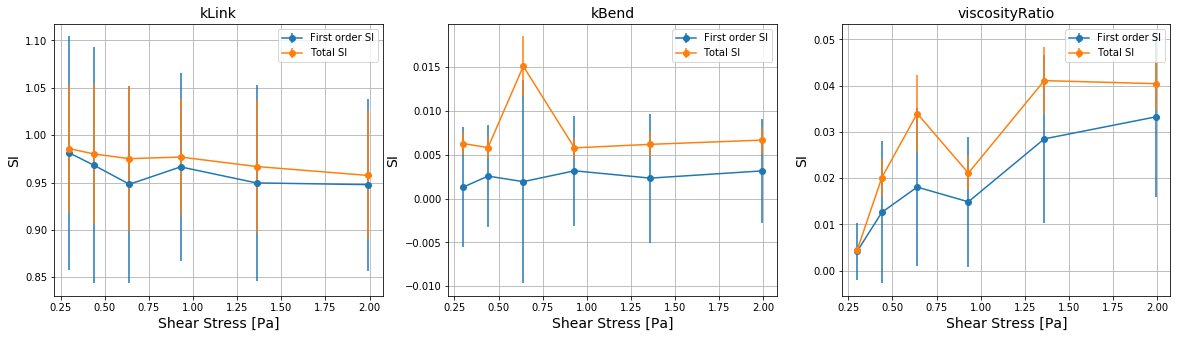

In [7]:
plt.figure(figsize=(20,5))
plt.title("Sobol indices",fontsize=14)
for n in range(len(model_params)):
    plt.subplot(1,3,n+1)
    plt.title(model_params[n],fontsize=14)
    plt.grid(True)
    plt.xlabel("Shear Stress [Pa]",fontsize=14)
    plt.ylabel("SI",fontsize=14)
    
    plt.errorbar(stress,S1[n],yerr=S1_conf[n],fmt="o-",label="First order SI")
    plt.errorbar(stress,ST[n],yerr=ST_conf[n],fmt="o-",label="Total SI")
    
    plt.legend()

plt.show()

## Setup TMCMC sampling

In [8]:
def evaluate_GP(params):
    kLink = params["kLink"]
    kBend = params["kBend"]
    viscosityRatio = params["viscosityRatio"]
    shearrate = params["shearrate"]
    
    arr = np.array([kLink,kBend,viscosityRatio,shearrate])[None,:]
    mean,std = predictionModel.predict(arr,return_std=True)
    return mean[0],std[0]

def model_prior(sample,enableInteriorViscosity):
    kLink_prior = uniform.pdf(sample[0],10.0,290.0)
    kBend_prior = uniform.pdf(sample[1],50.0,250.0)
    
    if enableInteriorViscosity:
        viscosityRatio_prior = uniform.pdf(sample[2],1.0,14.0)
        return np.prod([kLink_prior,kBend_prior,viscosityRatio_prior])
    else:
        return np.prod([kLink_prior,kBend_prior])

def model_sampler(n_samples,enableInteriorViscosity):
    kLink_samples = np.random.uniform(10.0,300.0,n_samples)
    kBend_samples = np.random.uniform(50.0,300.0,n_samples)
    
    if enableInteriorViscosity:
        viscosityRatio_samples = np.random.uniform(1.0,15.0,n_samples)
        return np.column_stack([kLink_samples,kBend_samples,viscosityRatio_samples])
    else:
        return np.column_stack([kLink_samples,kBend_samples])

def error_prior(sample):
    return np.prod(uniform.pdf(sample,0.0001,0.0999))

def error_sampler(n_samples):
    return np.random.uniform(0.0001,0.1,(n_samples,1))

## Sanity Check

### Healthy

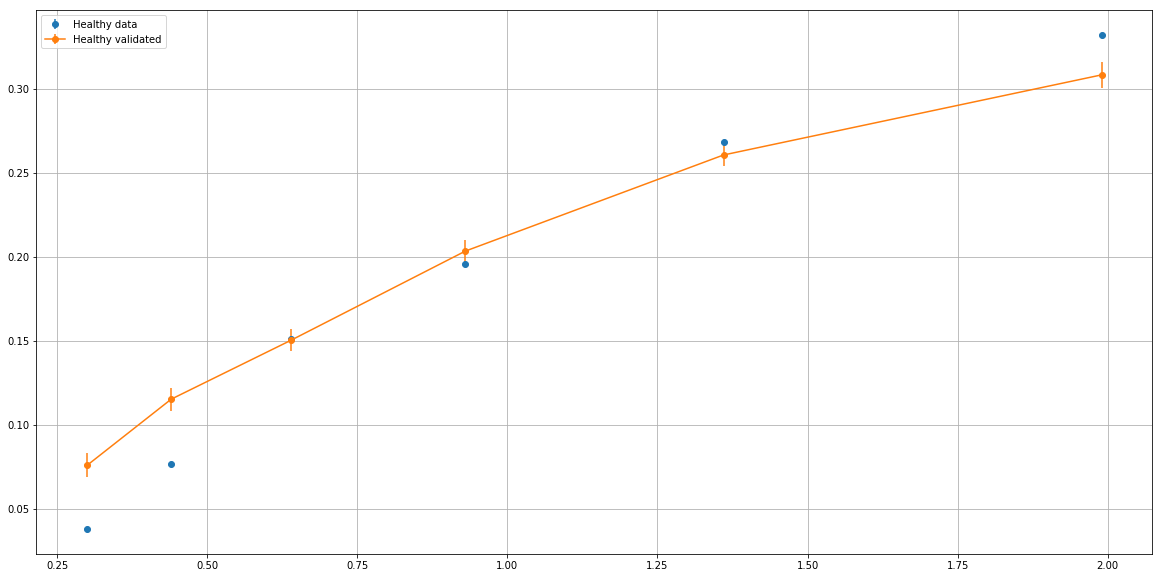

In [9]:
# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el = data.values[imin:imax,[1,2]].T

el_err = np.zeros(stress.shape)

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

healthy_samples = np.zeros((shearrate.shape[0],x_train.shape[1]))

healthy_samples[:,:-1] = np.array([50,80,5])
healthy_samples[:,-1] = shearrate

healthy_qoi,healthy_std = predictionModel.predict(healthy_samples,return_std=True)

plt.figure(figsize=(20,10))

plt.errorbar(stress,el,yerr=el_err,fmt='o',label="Healthy data")
plt.errorbar(stress,healthy_qoi,yerr=healthy_std,fmt='o-',label="Healthy validated")

plt.grid(True)
plt.legend()

plt.show()

### Treated

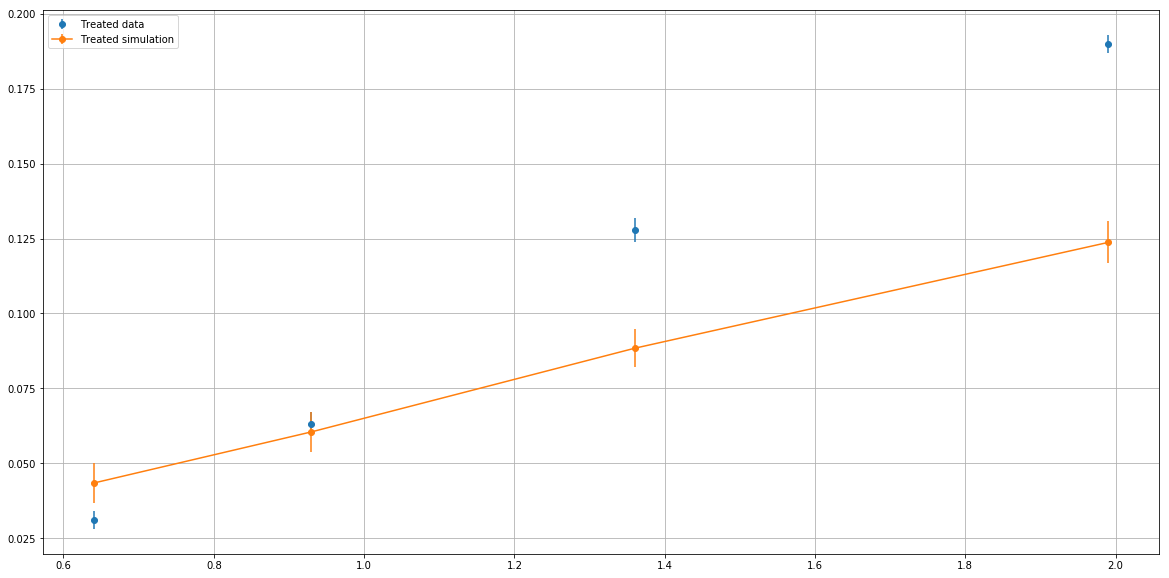

In [10]:
imin = 2
imax = 6

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,3,4]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

treated_samples = np.zeros((shearrate.shape[0],x_train.shape[1]))

treated_samples[:,:-1] = np.array([200,100,5.0])
treated_samples[:,-1] = shearrate

treated_qoi,treated_std = predictionModel.predict(treated_samples,return_std=True)

plt.figure(figsize=(20,10))

plt.errorbar(stress,el,yerr=el_err,fmt='o',label="Treated data")
plt.errorbar(stress,treated_qoi,yerr=treated_std,fmt='o-',label="Treated simulation")

plt.grid(True)
plt.legend()

plt.show()

## TMCMC sampling

In [11]:
imin=2
imax=6

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el = data.values[imin:imax,[1,2]].T

el_err = np.zeros(stress.shape)

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

In [12]:
n_samples = 1000

model_params = ["kLink","kBend","viscosityRatio"]
error_params = ["err"]
design_vars = ["shearrate"]

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Map model errors to data samples
error_mapping = ["err" for n in range(shearrate.shape[0])]

# Construct problem dict
problem = {"model_type":"python",
           "evaluate":evaluate_GP,
           "model_params":model_params,
           "error_params":error_params,
           "design_vars":design_vars,
           "input_data":shearrate,
           "output_data":el,
           "data_errors":el_err,
           "error_mapping":error_mapping,
           "model_prior":(lambda sample: model_prior(sample,1)),
           "model_sampler":(lambda n_samples: model_sampler(n_samples,1)),
           "error_prior":error_prior,
           "error_sampler":error_sampler
          }

TMCMC_sampler = TMCMC.TMCMC(problem,lmax=1,logpath=None,logstep=1e6)
df,qoi,c_err = TMCMC_sampler.sample(n_samples)

print(df)

Initializing...
Current max likelihood: 998227.0409981781
Calculating p for stage 1...
p: 0.005701193361150427
COV: 0.9999999974411712
Running stage 1...
Maximum chain length: 1
Current max likelihood: 2144852.157881109
Calculating p for stage 2...
p: 0.02716830264271226
COV: 0.9999999980643441
Running stage 2...
Maximum chain length: 1
Current max likelihood: 5227653.997894241
Calculating p for stage 3...
p: 0.13806559134836965
COV: 1.0000000069418682
Running stage 3...
Maximum chain length: 1
Current max likelihood: 10391878.236437483
Calculating p for stage 4...
p: 0.4769556040414183
COV: 1.000000002874279
Running stage 4...
Maximum chain length: 1
Current max likelihood: 11713264.534519875
Calculating p for stage 5...
p: 0.9693433951237737
COV: 0.9999999870113394
Running stage 5...
Maximum chain length: 1
Current max likelihood: 12357974.940334179
Calculating p for stage 6...
p: 1.0
COV: 0.05004071186366367
Running stage 6...
Maximum chain length: 1
Current max likelihood: 11750406

## Analyze results

In [13]:
method = "TMCMC"

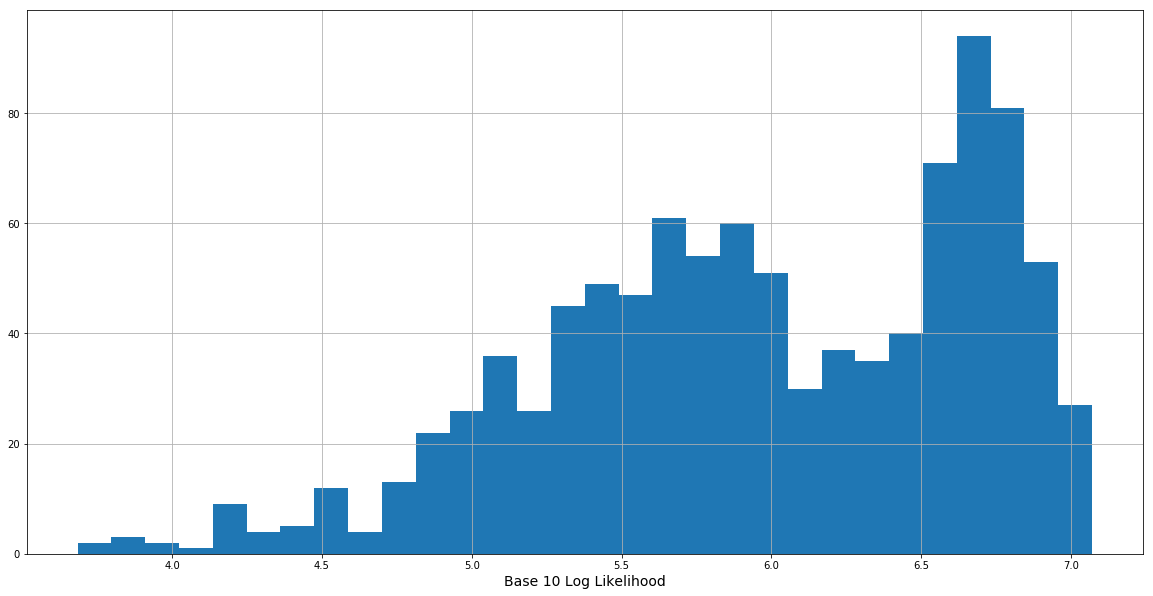

In [14]:
nbins = 30
plt.figure(figsize=(20,10))
plt.grid(True)

if method == "TMCMC":
    plt.xlabel(r"Base 10 Log Likelihood",fontsize=14)
    plt.hist(np.log10(df["likelihood"].values),bins=nbins)
    
plt.show()

In [15]:
if method == "TMCMC":
    for n in range(-8,9):
        print("Number of high densities larger than %e:" % (10**n),np.sum(df["likelihood"].values > 10**n))

Number of high densities larger than 1.000000e-08: 1000
Number of high densities larger than 1.000000e-07: 1000
Number of high densities larger than 1.000000e-06: 1000
Number of high densities larger than 1.000000e-05: 1000
Number of high densities larger than 1.000000e-04: 1000
Number of high densities larger than 1.000000e-03: 1000
Number of high densities larger than 1.000000e-02: 1000
Number of high densities larger than 1.000000e-01: 1000
Number of high densities larger than 1.000000e+00: 1000
Number of high densities larger than 1.000000e+01: 1000
Number of high densities larger than 1.000000e+02: 1000
Number of high densities larger than 1.000000e+03: 1000
Number of high densities larger than 1.000000e+04: 994
Number of high densities larger than 1.000000e+05: 907
Number of high densities larger than 1.000000e+06: 491
Number of high densities larger than 1.000000e+07: 14
Number of high densities larger than 1.000000e+08: 0


Best sample:
kLink             5.304897e+01
kBend             1.869582e+02
viscosityRatio    1.001913e+00
err               2.086892e-02
likelihood        1.175041e+07
Name: 15, dtype: float64


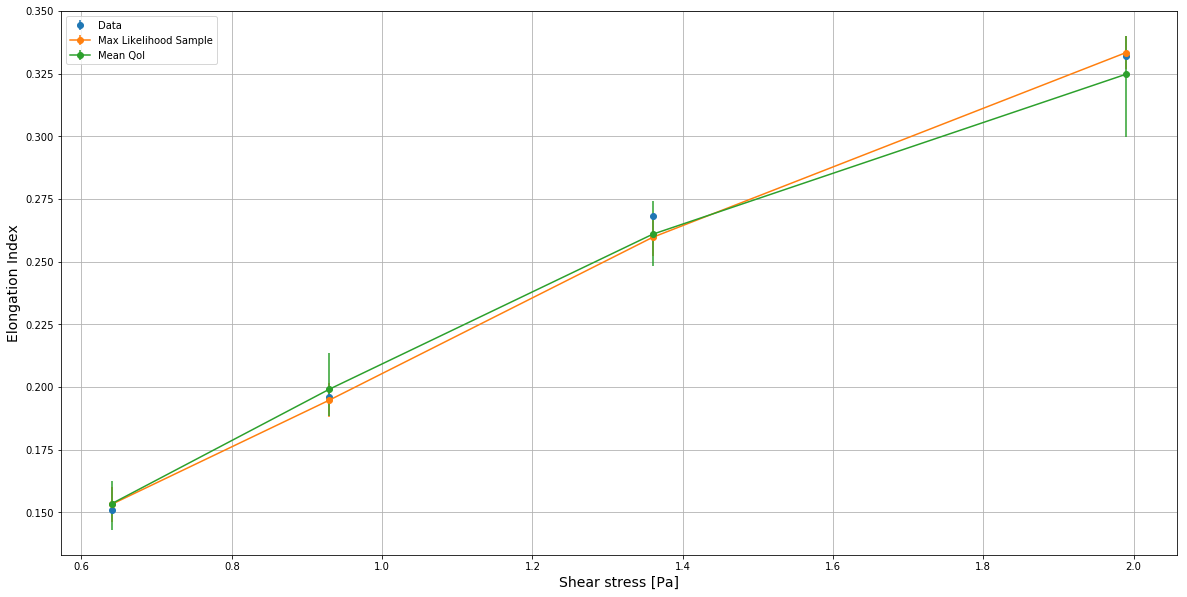

In [16]:
plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")

# Highest likelihood
if method == "TMCMC":
    mle = np.argmax(df["likelihood"].values)
    #print("Max likelihood:",sample_df["likelihood"].values[mle])
elif method == "ABCSubSim":
    mle = np.argmin(df["distance"].values)
    #print("Minimum distance:",sample_df["distance"].values[mle])

print("Best sample:")
print(df.loc[mle])
    
plt.errorbar(stress,qoi[mle],c_err[mle],fmt="o-",label="Max Likelihood Sample")

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

ptile = np.percentile(qoi,[2.5,97.5],axis=0)

ptile[0] = mean - ptile[0]
ptile[1] -= mean

plt.errorbar(stress,mean,yerr=ptile,fmt="o-",label="Mean QoI")

plt.legend()
plt.show()

In [17]:
"""
plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Plot all qoi
for n in range(qoi.shape[0]):
    plt.plot(stress,qoi[n])

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")
    
plt.legend()

plt.show()
"""

'\nplt.figure(figsize=(20,10))\nplt.xlabel("Shear stress [Pa]",fontsize=14)\nplt.ylabel("Elongation Index",fontsize=14)\n\nplt.grid(True)\n\n# Plot all qoi\nfor n in range(qoi.shape[0]):\n    plt.plot(stress,qoi[n])\n\n# Data\nplt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")\n    \nplt.legend()\n\nplt.show()\n'

## Parameter histograms

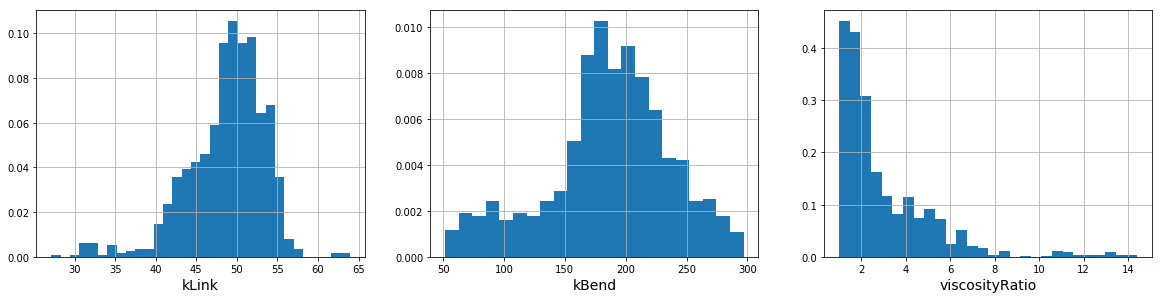

In [18]:
plt.figure(figsize=(20,10))
for n in range(len(model_params)):
    plt.subplot(2,3,n+1)
    plt.grid(True)
    plt.xlabel(model_params[n],fontsize=14)
    plt.hist(df[model_params[n]].values,bins="auto",density=True)
    
plt.show()

## Plot parameters in 2D

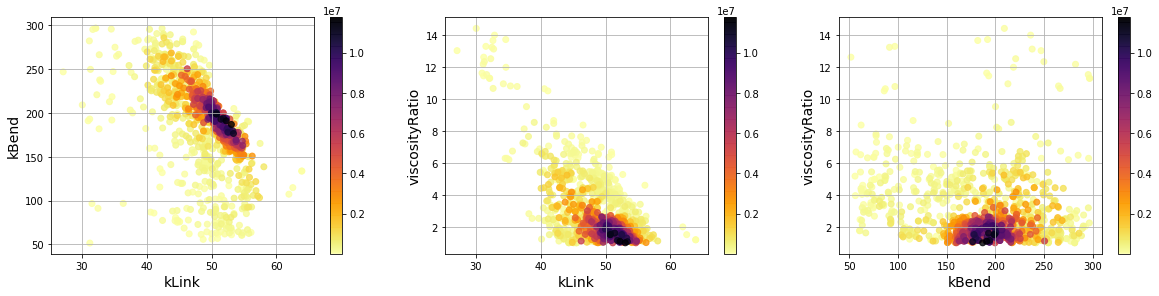

In [19]:
plt.figure(figsize=(20,20))

count = 1
for n in range(len(model_params)):
    for m in range(n,len(model_params)):
        if n != m:
            plt.subplot(4,3,count)
            plt.grid(True)
            plt.xlabel(model_params[n],fontsize=14)
            plt.ylabel(model_params[m],fontsize=14)
            if method == "TMCMC":
                order = np.argsort(df["likelihood"])
                plt.scatter(df[model_params[n]].values[order],df[model_params[m]].values[order],
                            c=df["likelihood"].values[order],cmap="inferno_r",alpha=0.8)
                
            elif method == "ABCSubSim":
                order = np.argsort(df["distance"])[::-1]
                plt.scatter(df[model_params[n]].values[order],df[params[m]].values[order],
                            c=df["distance"].values[order],cmap="inferno")
                
            plt.colorbar()
            count += 1

plt.show()

## Gaussian KDE

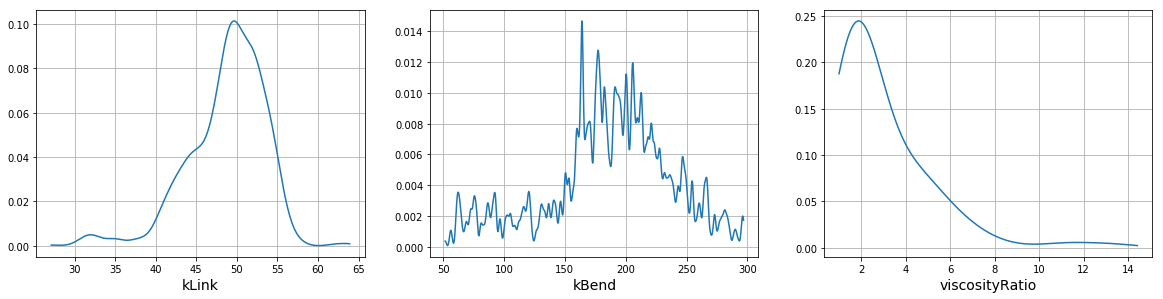

In [20]:
bandwidth = 1.0
plt.figure(figsize=(20,10))
for n in range(len(model_params)):
    vals = df[model_params[n]].values
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(vals[:,None])
    x_vals = np.linspace(np.min(vals),np.max(vals),1000)
    y_vals = np.exp(kde.score_samples(x_vals[:,None]))
    
    plt.subplot(2,3,n+1)
    plt.grid(True)
    plt.xlabel(model_params[n],fontsize=14)
    plt.plot(x_vals,y_vals)
    
plt.show()

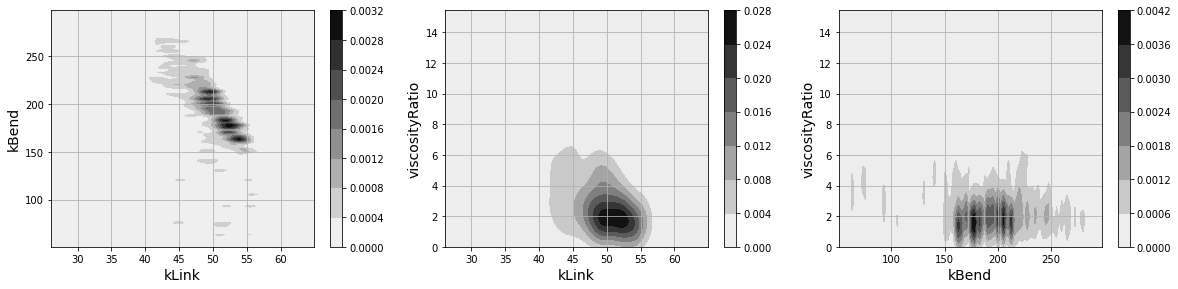

In [21]:
plt.figure(figsize=(20,20))

zoom = 1

count = 1
for n in range(len(model_params)):
    for m in range(n,len(model_params)):
        if n != m:
            vals = df[[model_params[n],model_params[m]]].values
            kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(vals)
            
            x = np.linspace(np.min(vals[:,0])-zoom,np.max(vals[:,0])+zoom,100)
            y = np.linspace(np.min(vals[:,1])-zoom,np.max(vals[:,1])+zoom,100)
            xx,yy = np.meshgrid(x,y)
            
            grid_flat = np.column_stack([xx.flatten(),yy.flatten()])
            grid_vals = np.exp(kde.score_samples(grid_flat)).reshape(xx.shape)
            
            #print(np.exp(kde.score_samples(grid_flat)))
            #print(xx.flatten())
            #print(grid_vals)
            
            plt.subplot(4,3,count)
            plt.grid(True)
            plt.xlabel(model_params[n],fontsize=14)
            plt.ylabel(model_params[m],fontsize=14)
            plt.contourf(xx,yy,grid_vals,cmap="gray_r")
            plt.colorbar()
            count += 1

plt.show()

In [22]:
"""
# Load simulation data
x = np.load("%s/train_hemocell_samples_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
y = np.load("%s/train_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

# Remove failed simulation outputs
x_discarded = x[(y < 0)[:,0],:]

plt.figure(figsize=(20,10))
for n,parameter in enumerate(model_params+design_vars):
    plt.subplot(2,3,n+1)
    plt.grid(True)
    plt.xlabel(parameter,fontsize=14)
    plt.hist(x_discarded[:,n],bins="auto",density=False)
    
plt.show()

print(model_params+design_vars)
print(x_discarded)
"""

'\n# Load simulation data\nx = np.load("%s/train_hemocell_samples_%s_%i_%i.npy" % (outputpath,mode,imin,imax))\ny = np.load("%s/train_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))\n\n# Remove failed simulation outputs\nx_discarded = x[(y < 0)[:,0],:]\n\nplt.figure(figsize=(20,10))\nfor n,parameter in enumerate(model_params+design_vars):\n    plt.subplot(2,3,n+1)\n    plt.grid(True)\n    plt.xlabel(parameter,fontsize=14)\n    plt.hist(x_discarded[:,n],bins="auto",density=False)\n    \nplt.show()\n\nprint(model_params+design_vars)\nprint(x_discarded)\n'